Initial version using TFID vectorizor and SVM

Data: 2018


In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
#import requests
#from bs4 import BeautifulSoup
import re
import os
import sys
from IPython.display import display, HTML
import re
import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import regexp_tokenize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from keras.preprocessing import text, sequence

In [2]:
#load file
file_name = open('2_Case_Query_2018.csv', encoding="UTF-8", errors='ignore')
data=pd.read_csv(file_name)
data.shape

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(77839, 49)

In [3]:
#dropping unnecessary columns
data.drop(labels=['CaseClosedDate__c', 'CaseCreatedDate__c','CaseOwnerEmail__c',
                  'CaseOwnerProfile__c','Case_Age_In_Business_Hours__c', 'Case_Type__c', 
                  'ClosedDate','ContactEmail', 'CountryofIssue__c', 'CreatedDate', 
                  'CustomerRegion__c','Customer_Priority__c', 'DevtrackCreationDate__c',
                  'DevtrackId__c', 'Escalated_days__c', 'Escalated_to_Tier_4__c', 'Escalation_Severity__c',
                  'Infinera_Responsibility_HH_MM_SS__c','EnterDetailedProblemDescription__c',
       'Infinera_Responsibility_mins__c', 'LastActivityDate__c',
       'LastModifiedDate', 'Last_Status_Change__c', 'NetworkImpact__c',
       'NetworkStatus__c', 'Number_of_Hours_No_Action__c', 'Origin',
       'OutageStarttoOutageStopminutes__c','Resolution_Time__c', 'ResponseDate__c', 'ServiceAccount__c',
      'SpecificEscalationRequestQuestion__c','ProductId__c','ProductLine__c',
       'StarttoOutageStopmins_mins__c', 'Status', 'SWVersion__c','Severity__c',
       'TACCaseStatus__c', 'Tier_4_Escalation_Status__c','ResolutionDetails__c',
       'Time_With_Customer__c', 'Time_With_Support__c'], axis=1, inplace=True)
data.head(3)

,AccountId,CaseNumber,Description,Priority,ResolutionCode__c,Subject
0,0015000000MOCkCAAX,259654.0,CAUTION: This email originated from outside of...,Medium,Hardware Replaced,00259654 / Colt Telecom / Minor / Infinera RMA...
1,00138000016DWjAAAW,259737.0,CAUTION: This email originated from outside of...,Medium,Duplicate Case,00259737 / null / Minor / Re: Power under Volt...
2,0015000000f1vhLAAQ,258154.0,2x LIC-T-XT36-100Q-ZC8 required.,Standard,Instant Bandwidth Problem,00258154 / euNetworks Fiber UK Ltd / Minor / E...


# Extracting Key words and Preprocessing

In [4]:
#functions for pre-processing text
def cleanString(comment):
    #stopWords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(str(comment))
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) ]
                              #if w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list)
    
    return returnString#, idx_list

def give_last(string):        
    #last_string=[]
    last_string=str(string).split("/")
    last_string=" ".join(str(x) for x in last_string[-1:])
    return last_string

def remove_almum_and_digits(string): 
    pattern = '[0-9]'
    string = re.sub(pattern, ' ', string)
    # Remove some special characters
    string = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' ', str(string))
    # Replace numbers and symbols with language
    returnString = re.sub(r'([\;\:\|#*_=;.,\-\n])', ' ', string)
    return returnString


In [5]:
data['Key_words']=data['Subject'].apply(give_last)
data['Key_words']=data['Key_words'].apply(remove_almum_and_digits)
data['Key_words']=data['Key_words'].apply(cleanString)
data[['Subject','Key_words']].head()

,Subject,Key_words
0,00259654 / Colt Telecom / Minor / Infinera RMA...,infinera rma case number colt tt fan fail stl d d
1,00259737 / null / Minor / Re: Power under Volt...,re power under voltage and pem failure alarm x...
2,00258154 / euNetworks Fiber UK Ltd / Minor / E...,emergency license required for marseille frank...
3,00258310 / GCI / Informational / OA compatibility,oa compatibility
4,need to refurbish/ECO rework,eco rework


In [6]:
from rake_nltk import Rake
#extracting keyworkds from Subject and Description
def extract_key_words(string):
    r = Rake()
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    
    # extracting the words by passing the text
    r.extract_keywords_from_text(string)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    returnString=list(key_words_dict_scores.keys())
    returnString=" ".join(str(x) for x in returnString)
    return returnString

data['keys_with_nouns']=data['Key_words'].apply(extract_key_words)
data[['Key_words','keys_with_nouns']].head()

,Key_words,keys_with_nouns
0,infinera rma case number colt tt fan fail stl d d,colt fail case infinera tt fan rma number stl
1,re power under voltage and pem failure alarm x...,pem power failure alarm xt mrwtn voltage
2,emergency license required for marseille frank...,marseille required deployment frankfurt licens...
3,oa compatibility,oa compatibility
4,eco rework,eco rework


In [7]:
words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(str(sent)) \
     if w.lower() in words or not w.isalpha())

data['keys_filtered']=data['keys_with_nouns'].apply(clean_sent)
data[['Key_words','keys_with_nouns','keys_filtered']].head()

,Key_words,keys_with_nouns,keys_filtered
0,infinera rma case number colt tt fan fail stl d d,colt fail case infinera tt fan rma number stl,colt fail case fan number
1,re power under voltage and pem failure alarm x...,pem power failure alarm xt mrwtn voltage,power failure alarm voltage
2,emergency license required for marseille frank...,marseille required deployment frankfurt licens...,deployment license emergency
3,oa compatibility,oa compatibility,compatibility
4,eco rework,eco rework,rework


# Analysis of Resolution codes

In [8]:
print('Number of unique Resolution Code: ',len(data['ResolutionCode__c'].unique()))
codes=[]#list(data['ResolutionCode__c'].unique())
count_of_codes=[]
codes_grouped=data.groupby('ResolutionCode__c')
for code, count in codes_grouped: 
    codes.append(code)
    count_of_codes.append(len(count))
    
df=pd.DataFrame({
    'Resolution_code':codes,
    'Count':count_of_codes
})    

odd_codes=['Other','Question','Other Reason','Duplicate Case']
df[df['Resolution_code'].isin(odd_codes)]

Number of unique Resolution Code:  72


,Count,Resolution_code
20,1032,Duplicate Case
51,740,Other
52,379,Other Reason
55,813,Question


In [9]:
print('Total Number of cases before filtering Duplicate cases: ',df['Count'].sum())

#Removing Duplicate Cases
data=data[data.ResolutionCode__c!='Duplicate Case']
df=df[df.Resolution_code!='Duplicate Case']

print('Total Number of cases after filtering Duplicate cases: ',df['Count'].sum())

Total Number of cases before filtering Duplicate cases:  28806
Total Number of cases after filtering Duplicate cases:  27774


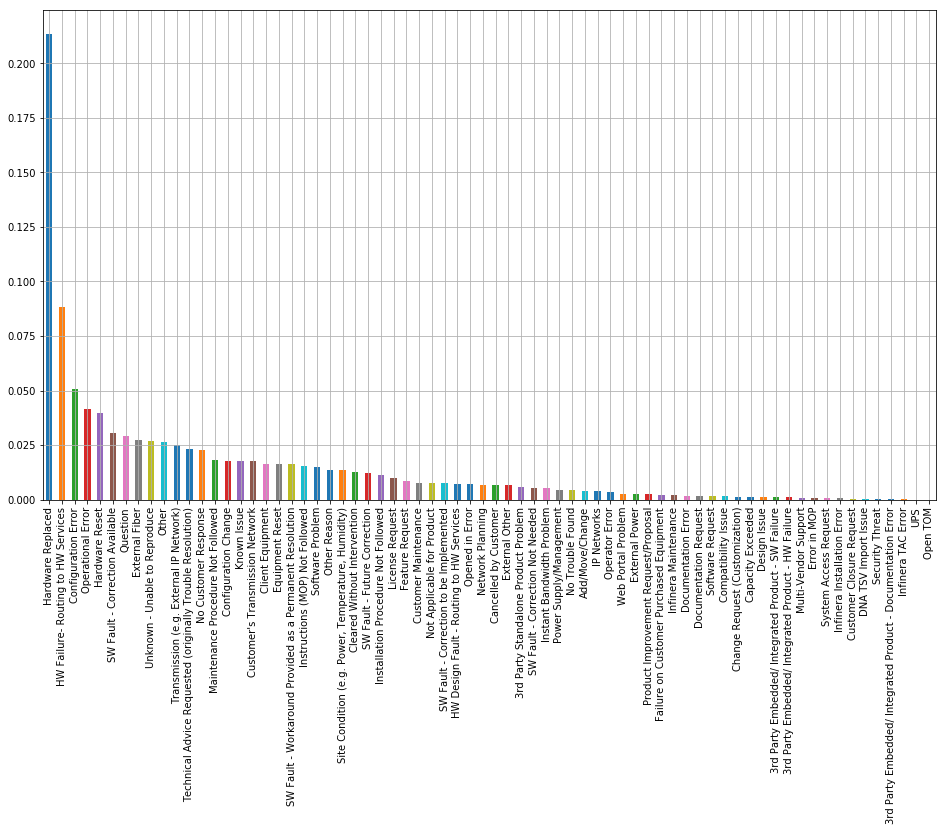

In [10]:
data.ResolutionCode__c.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

# Splitting the data

In [11]:
data['ResolutionCode__c'] = data['ResolutionCode__c'].astype(str)
labels = data['ResolutionCode__c']
text = data['keys_filtered']

X_train, X_test, y_train, y_test = train_test_split(text, labels, random_state=0, test_size=0.3)
X_train.head()

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


16682    loss optical signal
25532    request license key
18656               fana fan
11501         coe problem ba
49720                       
Name: keys_filtered, dtype: object

# Training with SVM

In [12]:
from sklearn.svm import LinearSVC
#import sklearn.calibration.CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder


In [13]:
svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 

In [14]:
model = Pipeline([('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clf)])

In [15]:
model.fit(X_train, y_train)

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...lty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='sigmoid'))])

In [16]:
model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...lty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='sigmoid'))])>

In [17]:
predictions = model.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
print('Testing accuracy %s' % accuracy_score(y_test, predictions))
print('Testing F1 score: {}'.format(f1_score(y_test, predictions, average='weighted')))

Testing accuracy 0.6620231740658769
Testing F1 score: 0.5676085610769569


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
predict=["Alien WL - Not working in DNA-M."]

In [66]:
from sklearn.externals import joblib
#filename = 'finalized_model.sav'
joblib.dump(model, filename)

loaded_model = joblib.load(filename)
result = loaded_model.predict_proba(predict)*100

In [67]:
result

array([[9.40783617e-03, 4.36311302e-02, 5.81528862e-02, 3.14095703e-01,
        3.23886173e-02, 1.18706433e-01, 6.71290473e-02, 3.47035952e-02,
        6.08252517e-01, 2.27948483e-01, 1.75066636e-02, 7.85837855e-01,
        3.86484299e-01, 2.50609350e-02, 1.41229715e-01, 2.09919366e-01,
        9.74693044e-03, 6.95594592e-02, 5.85746100e-02, 3.78239894e-02,
        3.49728288e-01, 1.90589558e-02, 2.70736513e-01, 1.48351624e-01,
        9.66765972e-02, 4.88272956e-02, 3.70450906e-01, 2.96255143e-02,
        2.00358960e-02, 2.08040526e+01, 2.52848123e+00, 6.58160327e-02,
        1.75586178e-02, 7.50490222e-03, 3.84479355e-03, 2.98209985e-01,
        2.03876291e-02, 1.18232929e-01, 9.33716857e-01, 1.53946455e-02,
        3.58732175e-01, 1.05918308e-02, 3.97894211e-02, 1.02204743e+00,
        1.66446405e-01, 1.05208191e-01, 3.84479355e-03, 1.01822204e-01,
        3.74020954e-01, 1.23588053e-01, 1.09276810e+00, 4.66509809e-02,
        1.64704191e-01, 5.27275433e-02, 1.23621979e+00, 2.848509

In [22]:
data_pred = pd.DataFrame(columns=['Category', 'probability'])
data_pred['Category'] = model.classes_
data_pred['probability'] = pd.DataFrame((model.predict_proba(predict)*100).T, columns=['probability'])
data_pred=data_pred[data_pred.Category!='nan']
data_pred.sort_values('probability', ascending = False).head(3)

,Category,probability
12,Configuration Error,19.070274
55,SW Fault - Correction Available,7.238690
29,Hardware Replaced,6.545316


In [43]:
from sklearn.externals import joblib
joblib.dump(model, 'prediction_model.pkl')

['prediction_model.pkl']

In [22]:
model.predict_proba(predict)*100
print(metrics.classification_report(y_test,model.predict(X_test)))

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                                              precision    recall  f1-score   support

3rd Party Embedded/ Integrated Product - Documentation Error       0.00      0.00      0.00         1
         3rd Party Embedded/ Integrated Product - HW Failure       0.00      0.00      0.00         6
         3rd Party Embedded/ Integrated Product - SW Failure       0.00      0.00      0.00        11
                        3rd Party Standalone Product Problem       0.00      0.00      0.00        52
                                             Add/Move/Change       0.20      0.08      0.11        25
                                       Cancelled by Customer       0.00      0.00      0.00        56
                                           Capacity Exceeded       0.00      0.00      0.00         9
                              Change Request (Customization)       0.00      0.00      0.00        16
                                Cleared Without Intervention       0.00      0.00

# Testing out pickle files for UI

In [93]:
import gc
import pickle
file = open('prediction_model.pkl', 'rb')
gc.disable()
Mdl=pickle.load(file)

EOFError: 

# Other Models

In [81]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])
clf_2 = Pipeline([
    ('vect', HashingVectorizer(non_negative=True)),
    ('clf', MultinomialNB()),
])
clf_3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

svm = LinearSVC()
svm_clf = CalibratedClassifierCV(svm) 
clf_4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', svm_clf),
])
clf_5 = Pipeline([
    ('vect', HashingVectorizer(non_negative=True)),
    ('clf', svm_clf),
])
clf_6 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', svm_clf),
])
clfs = [clf_1, clf_2, clf_3,clf_4, clf_5, clf_6]
clf_names=['Naive Bayes with CountVectorizor','Naive Bayes with HashingVectorizer','Naive Bayes with TfidVectorizor',
           'SVM with CountVectorizor','SVM with HashingVectorizer','SVM with TfidVectorizor',]

In [82]:
from sklearn.model_selection  import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold( n_splits=K,random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print (np.mean(scores), sem(scores))

In [84]:
i=0
for clf in clfs:
    print(clf_names[i])
    evaluate_cross_validation(clf, data['keys_filtered'],data['ResolutionCode__c'], 5)
    print('-'*20)
    i=i+1

Naive Bayes with CountVectorizor
[0.57668272 0.63657076 0.42178244 0.65288718 0.64859059]
0.5873027374066452 0.043585899447750695
--------------------
Naive Bayes with HashingVectorizer


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in versi

[0.71468559 0.63103763 0.37139509 0.73276479 0.74363648]
0.6387039161094574 0.0696937179049779
--------------------
Naive Bayes with TfidVectorizor
[0.68812655 0.64627002 0.38584728 0.71779181 0.72313   ]
0.6322331307003066 0.06309105602793266
--------------------
SVM with CountVectorizor


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warnin

[0.70654863 0.65277959 0.39007877 0.73224399 0.74090229]
0.6445106525849559 0.06543743346356069
--------------------
SVM with HashingVectorizer


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\feature_extraction\hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too fe

[0.70602786 0.6555787  0.38825597 0.7305514  0.74194388]
0.6444715629638481 0.06575316189269131
--------------------
SVM with TfidVectorizor


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warnin

[0.70479104 0.65505794 0.38727947 0.7302259  0.73973049]
0.6434169670076428 0.06569657104147919
--------------------
